todo
- torch 기반으로 변경

# 사용법
---
[구글 공유 PDF](https://drive.google.com/file/d/1v7szhnRFldttqwgL3H5cqlqdHh-4l9Bt/view?usp=drive_link)

# 설정
---

In [30]:
# True  : 스크린샷 중복 불가
# False : 스크린샷 중복 사용 허용
UNIQUE_SAMPLING = True
# 예시 업로드 이미지 사용
USE_SAMPLE_IMG = True


# 보정 0(무보정) -> 1.0 (원본 이미지)
alpha = 0.2

# 해상도 (height, width)
# (30, 30)   ~  분   /  Mb
# (60, 60)   ~  분   /  Mb
# (120, 120) ~  분  /  Mb
# (180, 180) ~ * RAM 부족으로 셧다운
TARGET_GRID = (60, 60)

pixel_size = 54 # 540, 270, 54

# Init
---

In [31]:
try:
    from google.colab import output, files
    from IPython.display import display, update_display, HTML

    IS_COLAB = True

    ! pip install lpips
    if (pixel_size==54):
        # updated: 2025.06.26
        # https://drive.google.com/file/d/1XSklUJZvBvpSUWnk9Aow2SVeppgOHGNW/view?usp=drive_link
        !gdown --id 1XSklUJZvBvpSUWnk9Aow2SVeppgOHGNW --output dataset.npz
    elif (pixel_size==270):
        # updated: 2025.06.12
        # https://drive.google.com/file/d/1MCs9WNbBBrrQJRalCP3eIcJv2jdJIJlw/view?usp=drive_link
        !gdown --id 1MCs9WNbBBrrQJRalCP3eIcJv2jdJIJlw --output dataset.npz
    elif (pixel_size==540):
        # updated: 2025.06.12
        # https://drive.google.com/file/d/1ndRAaihKXP-0VH7b2qTxVkPPyIOU9R46/view?usp=drive_link
        !gdown --id 1ndRAaihKXP-0VH7b2qTxVkPPyIOU9R46 --output dataset.npz
    else:
        raise NameError("Wrong pixel size.")

    # https://drive.google.com/file/d/1eOgtmM39eFO04nHVEoKO-fd1tiit7Wc_/view?usp=drive_link
    !gdown --id 1eOgtmM39eFO04nHVEoKO-fd1tiit7Wc_ --output sample.jpg

    print_cmd = lambda ss='' : display(HTML(f"<p>{ss}</p>"), display_id='progress')
    clear_cmd = output.clear
    if (USE_SAMPLE_IMG):
        get_target = lambda : 'sample.jpg'
    else:
        get_target = lambda : list(files.upload().keys())[0]

except:
    from IPython.display import clear_output

    IS_COLAB = False

    print_cmd = lambda ss='' : print(ss)
    clear_cmd = lambda : None
    get_target = lambda : 'target.png'

clear_cmd()

In [32]:
# import lib
import cv2
import matplotlib.pyplot as plt
import os
from copy import deepcopy
from time import perf_counter, sleep
from scipy.stats import norm
import gc
import numpy as np
# Eval: LPIPS
import lpips
import torch
from PIL import Image
import torchvision.transforms as transforms
# Eval:  deltaE
from skimage import color
# Eval: SSIM
from skimage.metrics import structural_similarity as ssim

clear_cmd()

## Utile
---

In [33]:
def resize(source:np.array, size:tuple, interpolation=cv2.INTER_LINEAR):
    """
    Resize image to target size.
    if there is ratio mismatch, center crop the image.
    """
    h, w = size
    rate = w/h
    s_h, s_w = source.shape[:2]
    s_rate = s_w/s_h

    if (rate < s_rate):
        crop_h, crop_w = s_h, int(s_h*rate)
        offset_h, offset_w = 0, (s_w-crop_w)//2
    else:
        crop_h, crop_w = int(s_w/rate), s_w
        offset_h, offset_w = (s_h-crop_h)//2, 0


    cropped = source[offset_h:offset_h+crop_h, offset_w:offset_w+crop_w]
    resized = cv2.resize(cropped, size[::-1], interpolation=interpolation)
    return resized

In [34]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [35]:
def getNormDistribution(data_list):
    mu = np.mean(data_list)
    sigma = np.std(data_list)

    x_min = min(data_list)
    x_max = max(data_list)
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 500)

    pdf = norm.pdf(x, mu, sigma)

    return x, pdf

In [36]:
def spiral_from_center(width, height):
    matrix = [[i*width+j for j in range(width)] for i in range(height)]

    rows = len(matrix)
    cols = len(matrix[0])
    visited = [[False]*cols for _ in range(rows)]

    x = rows // 2
    y = cols // 2

    result = []
    result.append(matrix[x][y])
    visited[x][y] = True

    directions = [(0,1), (1,0), (0,-1), (-1,0)]

    steps = 1
    while len(result) < rows * cols:
        for d in range(2):
            dx, dy = directions.pop(0)
            directions.append((dx, dy))
            for _ in range(steps):
                x += dx
                y += dy
                if 0 <= x < rows and 0 <= y < cols and not visited[x][y]:
                    result.append(matrix[x][y])
                    visited[x][y] = True
        steps += 1
    return result

In [37]:
def LPIIPS():
    """
    LPIPS function.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    lpips_model = lpips.LPIPS(net='vgg')
    lpips_model = lpips_model.to(device)
    transform = transforms.Compose([
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    def func(img1, img2s, gain, mask):
      if img1.shape != img2s[0].shape:
        raise ValueError(f"ref and source must have the same shape(ref:{img1.shape}/source:{img2s[0].shape})")



      img1 = transform(img1)
      img2_batch = torch.stack([transform(img) for i, img in enumerate(img2s) if mask[i] == 0]).to(device)  # Shape: [N, C, H, W]
      gain_masked = torch.stack([g for i, g in enumerate(gain) if mask[i] == 0]).to(device)  # Shape: [N, C, H, W]
      img1_batch = img1.expand(img2_batch.shape[0], -1, -1, -1).to(device)
      indexs = [i for i in range(img2s.shape[0]) if mask[i] == 0]

      with torch.no_grad():
        lpips_score = lpips_model(img1_batch, img2_batch).squeeze()
        gainedScore = lpips_score * gain_masked

      best = int(torch.argmin(gainedScore).cpu().item())
      if lpips_score.ndim == 0:
          return indexs[best], float(lpips_score.cpu().item())
      else:
          return indexs[best], float(lpips_score[best].cpu())


    return func

In [38]:
def load_dataset():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset = np.load("dataset.npz")
    samples = torch.from_numpy(dataset['sample']).permute(0, 3, 1, 2).float().to(device)
    labels = torch.from_numpy(dataset['label']).to(device)
    imgs = dataset['img'].astype(np.uint8)

    return samples, labels, imgs

In [39]:
if (pixel_size==54):
    FRAME_SIZE = (54, 96)
elif (pixel_size==270):
    FRAME_SIZE = (270, 480)
elif (pixel_size==540):
    FRAME_SIZE = (540, 960)
else:
    raise NameError("Wrong pixel size.")

SAMPLE_GRID_SIZE = (27, 48)
TARGET_SAMPLE_SIZE = (SAMPLE_GRID_SIZE[0]*TARGET_GRID[0], SAMPLE_GRID_SIZE[1]*TARGET_GRID[1])
TARGET_SIZE = (FRAME_SIZE[0]*TARGET_GRID[0], FRAME_SIZE[1]*TARGET_GRID[1])
# SNR     : 빠름
# deltaE  : 느림
# SSIM    : 느림
# lpips   : 빠름 (권장)
COMPARE_FORMAT = cv2.COLOR_BGR2RGB
COMPARE_FUNCTION = LPIIPS()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


# Main
---

In [40]:
print(f"""작은 이미지 크기: {FRAME_SIZE[0]}x{FRAME_SIZE[1]}px
해상도\t\t: {TARGET_GRID[0]}x{TARGET_GRID[1]}

결과 이미지 크기: {TARGET_SIZE[0]}x{TARGET_SIZE[1]}px""")

작은 이미지 크기: 54x96px
해상도		: 60x60

결과 이미지 크기: 3240x5760px


## 적합한 이미지 탐색을 위한 비교 이미지 생성

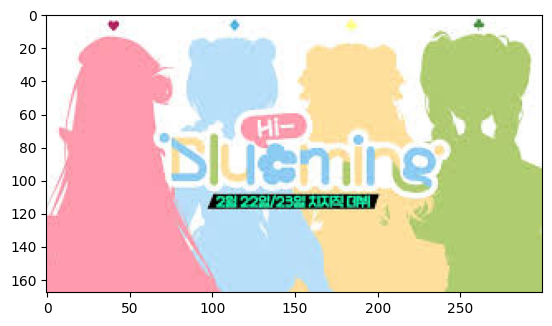

In [41]:
filename = get_target()
target_origin = cv2.imread(filename)
plt.imshow(cv2.cvtColor(target_origin, cv2.COLOR_BGR2RGB))

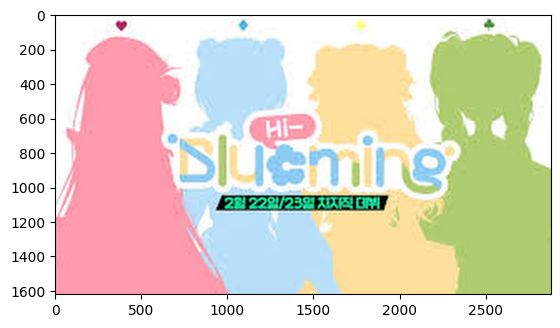

In [42]:
target_resized = resize(target_origin, TARGET_SAMPLE_SIZE, interpolation=cv2.INTER_LANCZOS4)
plt.imshow(cv2.cvtColor(target_resized, cv2.COLOR_BGR2RGB))

## 적합한 이미지 탐색 및 결과

1065 memories loaded.


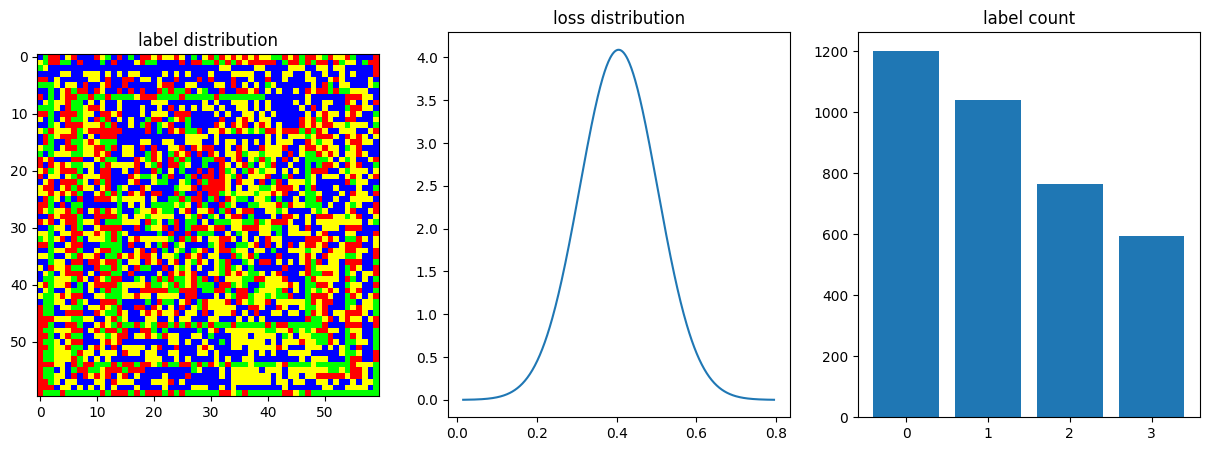

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_color = [[255, 0, 0], [0, 255, 255], [0, 0, 255], [0, 255, 0]]
label_cnt = np.ones(4)*10

timer = perf_counter()

# load dataset
samples, labels, imgs = load_dataset()
print(f"{labels.shape[0]} memories loaded.")

# Init imgs
target = torch.from_numpy(target_resized).permute(2, 0, 1).float()
mosaic_map = np.zeros(TARGET_GRID)
label_map = np.zeros((*TARGET_GRID, 3))

L = labels.shape[0]
gains = torch.ones(L).to(device)
mask = torch.zeros(L).to(device)
N = TARGET_GRID[0]*TARGET_GRID[1]
loss = np.zeros(N)
loop_cnt = 0

order = spiral_from_center(*TARGET_GRID)
for ii, i in enumerate(order):
    x = i%TARGET_GRID[0]
    y = i//TARGET_GRID[0]
    # get partial img
    x0, y0 = x*SAMPLE_GRID_SIZE[0], y*SAMPLE_GRID_SIZE[1]
    x1, y1 = x0+SAMPLE_GRID_SIZE[0], y0+SAMPLE_GRID_SIZE[1]
    piece = target[:, x0:x1, y0:y1]

    # get loss
    label_softmax = label_cnt/sum(label_cnt)
    for a, b in enumerate(labels):
        gains[a] = label_softmax[b]
    maxIndex, maxSNR = COMPARE_FUNCTION(piece, samples, gains, mask)

    label_map[x, y] = label_color[labels[maxIndex]]
    mosaic_map[x, y] = int(maxIndex)

    label_cnt[labels[maxIndex]] += 1
    loss[i] = maxSNR
    delay = perf_counter() - timer

    M = ii+1
    print_cmd(f"{M/N*100:.2f}% (remain: {delay/M*(N-M)/60:.2f}min)<br>    └[{x}, {y}]    label: {labels[maxIndex]}-{maxIndex} ({maxSNR:0.10f})<br>    └Reuse count: {loop_cnt}<br>    └Label count: {label_cnt[0]}, {label_cnt[1]}, {label_cnt[2]}, {label_cnt[3]}")

    if (UNIQUE_SAMPLING):
        mask[maxIndex] = 1
        if (torch.sum(mask) == L):
            loop_cnt += 1
            for j in range(L):
                mask[j] = 0

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(label_map.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title("label distribution")

plt.subplot(1, 3, 2)
x, normdistribution = getNormDistribution(loss)
plt.plot(x, normdistribution)
plt.title("loss distribution")

plt.subplot(1, 3, 3)
plt.bar([0, 1, 2, 3], label_cnt-10)
plt.title("label count")
plt.show()

## 합성 및 보정

In [44]:
timer = perf_counter()
mosaic = np.zeros((*TARGET_SIZE, 3), dtype=np.uint8)
for x in range(TARGET_GRID[0]):
    for y in range(TARGET_GRID[1]):
        i = x*TARGET_GRID[1] + y
        x0, y0 = x*FRAME_SIZE[0], y*FRAME_SIZE[1]
        x1, y1 = x0+FRAME_SIZE[0], y0+FRAME_SIZE[1]
        mosaic[x0:x1, y0:y1, :] = imgs[int(mosaic_map[x, y])]

        delay = perf_counter() - timer
        M = i+1
        print_cmd(f"{M/N*100:.2f}% (remain: {delay/M*(N-M)/60:.2f}min)<br>    └[{x}, {y}]")

In [45]:
alpha = 0.0
mask = resize(target_origin, TARGET_SIZE, interpolation=cv2.INTER_LANCZOS4)
mosaic_masked = cv2.addWeighted(mosaic, 1.0-alpha, mask, alpha, 0, dtype=cv2.CV_32F)

if (pixel_size == 54):
  plt.figure(figsize=(15, 10))
  plt.imshow(cv2.cvtColor(mosaic_masked.astype(np.uint8), cv2.COLOR_BGR2RGB))
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 결과 이미지 저장

In [46]:
cv2.imwrite("mosaic_masked.jpg", mosaic_masked)
cv2.imwrite("mosaic.jpg", mosaic)

True

In [47]:
if (IS_COLAB):
    files.download("mosaic_masked.jpg")
    files.download("mosaic.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>